In [ ]:
from pathlib import Path
import sys, sqlite3, yaml, pandas as pd

# Текущая рабочая директория Jupyter
cwd = Path.cwd()

# Если CWD = Project/notebooks, то корень проекта = parent
project_root = str(cwd.parent)

# Добавляем корень проекта в sys.path (в начало, чтобы он имел приоритет)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

pd.set_option("display.width", 2000)     # максимальная ширина в символах
pd.set_option("display.max_colwidth", None)

from config import DB_SNAPSHOT_PATH, DEFAULT_CONFIG_PATH

/content/_tmp_repo
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 59 (delta 1), reused 31 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (59/59), 390.32 KiB | 2.69 MiB/s, done.
From https://github.com/Tasyaak/TPPOProject
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [ ]:
with open(DEFAULT_CONFIG_PATH, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

sql = cfg["data"]["sql"]
with sqlite3.connect(DB_SNAPSHOT_PATH) as conn:
    df = pd.read_sql(sql, conn)

df.head()

,label,error_text_tokens,ctx_tokens,ctx_numeric
0,1,"[""C2065"", ""<IDENT>"", ""необъявленный"", ""идентиф...","[""F_TOK=INT"", ""F_TOK=<ID_VAR_SCALAR_DECL>"", ""F...","{""N_TOK__LOCAL_TOK_LEN"": 48.0, ""N_CORE__HAS_CO..."
1,1,"[""C2065"", ""<IDENT>"", ""необъявленный"", ""идентиф...","[""F_TOK=<ID_VAR_SCALAR_USE>"", ""F_TOK=OP_<<"", ""...","{""N_TOK__LOCAL_TOK_LEN"": 14.0, ""N_CORE__HAS_CO..."
2,1,"[""C2065"", ""<IDENT>"", ""необъявленный"", ""идентиф...","[""F_TOK=}"", ""F_USING_NS__NS=std"", ""F_DECL__VAR...","{""N_TOK__LOCAL_TOK_LEN"": 1.0, ""N_CORE__HAS_COR..."
3,1,"[""C2065"", ""<IDENT>"", ""необъявленный"", ""идентиф...","[""F_TOK=}"", ""F_USING_NS__NS=std"", ""F_DECL__VAR...","{""N_TOK__LOCAL_TOK_LEN"": 1.0, ""N_CORE__HAS_COR..."
4,1,"[""C2065"", ""<IDENT>"", ""необъявленный"", ""идентиф...","[""F_TOK=<ID_TYPE_USER_USE>"", ""F_TOK=OP_*"", ""F_...","{""N_TOK__LOCAL_TOK_LEN"": 82.0, ""N_CORE__HAS_CO..."


In [ ]:
from ml_helpers.vectorizers import build_vectorizer_from_cfg
from sklearn.model_selection import train_test_split


y = df["label"].astype(int).to_numpy()

feat = build_vectorizer_from_cfg(cfg)
df_X = df.drop(columns=["label"])

X_dev, X_test, y_dev, y_test = train_test_split(
    df_X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

In [ ]:
# from joblib import Memory
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV # type: ignore
from sklearn.pipeline import Pipeline
from ml_helpers.tuning import _import_obj, make_cv
from ml_helpers.tuning import prepare_param_grids, _infer_max_resources_from_grid


active = cfg["active_model"]
m_cfg = cfg["models"][active]

Estimator = _import_obj(m_cfg["type"])
est = Estimator(**(m_cfg.get("params", {}) or {}))

# cache_dir = "/tmp/sk_cache"
# memory = Memory(cache_dir, verbose=0)

# pipe = Pipeline([("feat", feat), ("clf", est)], memory=memory)

pipe = Pipeline([("feat", feat), ("clf", est)])

cv_name = cfg["training"]["cv_strategy"]
strat_cfg = next(s for s in cfg["cross_val_score"]["strategies"] if s["name"] == cv_name)
cv = make_cv(strat_cfg)

n_jobs = cfg["training"]["tuning"]["n_jobs"]
method = cfg["training"]["tuning"]["method"]
verbose = cfg["training"]["tuning"].get("verbose", 0)
error_score = cfg["training"]["tuning"].get("error_score", "raise")

h_cfg = m_cfg.get(method, {}) or {}
return_train_score = h_cfg.get("return_train_score", False)
random_state = h_cfg.get("random_state", None)

param_grid = prepare_param_grids(m_cfg)

scoring_cfg = cfg["training"]["tuning"]["scoring"]
refit_cfg = cfg["training"]["tuning"]["refit"]

is_halving = method in {"halving_grid", "halving_random"}

if is_halving:
    if isinstance(refit_cfg, str):
        scoring = refit_cfg
        refit = True
    else:
        scoring = scoring_cfg
        refit = refit_cfg
        if isinstance(scoring, (list, tuple, dict)):
            raise ValueError("Halving* не поддерживает несколько метрик")
else:
    scoring = scoring_cfg
    refit = refit_cfg

def _infer_max_resources_from_grid(param_grid, resource_name : str):
    vals = []
    grids = param_grid if isinstance(param_grid, list) else [param_grid]
    for g in grids:
        if resource_name in g:
            v = g[resource_name]
            if isinstance(v, (list, tuple)):
                vals.extend([x for x in v if x is not None])
    return max(vals) if vals else None


if method == "none" or not param_grid:
    pipe.fit(df_X, y)
    best_estimator = pipe
    best_params = {}
else:
    if method == "grid":
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring=scoring,
            refit=refit,
            cv=cv,
            n_jobs=n_jobs,
            verbose=verbose,
            error_score=error_score,
            return_train_score=return_train_score,
        )
    elif method == "random":
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_grid,
            scoring=scoring,
            refit=refit,
            cv=cv,
            n_jobs=n_jobs,
            verbose=verbose,
            error_score=error_score,
            return_train_score=return_train_score,
            random_state=random_state,
        )
    elif method in {"halving_grid", "halving_random"}:

        factor = h_cfg.get("factor", 3)
        resource = h_cfg.get("resource", "n_samples")
        min_resources = h_cfg.get("min_resources", "exhaust" if method == "halving_grid" else "smallest")
        max_resources = h_cfg.get("max_resources", "auto")
        aggressive_elimination = h_cfg.get("aggressive_elimination", False)

        # Если ресурс НЕ n_samples, max_resources обязан быть int (не "auto")
        if resource != "n_samples" and max_resources == "auto":
            inferred = _infer_max_resources_from_grid(param_grid, resource)
            if inferred is None:
                raise ValueError(
                    f"resource={resource!r} => max_resources must be set explicitly "
                    f"(or include {resource!r} in the grid so it can be inferred)."
                )
            max_resources = int(inferred)

        if method == "halving_grid":
            search = HalvingGridSearchCV(
                estimator=pipe,
                param_grid=param_grid,
                factor=factor,
                resource=resource,
                min_resources=min_resources,
                max_resources=max_resources,
                aggressive_elimination=aggressive_elimination,
                cv=cv,
                scoring=scoring,
                refit=refit,
                n_jobs=n_jobs,
                verbose=verbose,
                error_score=error_score,
                return_train_score=return_train_score,
                random_state=random_state,
            )
        else:
            n_candidates = h_cfg.get("n_candidates", "exhaust")

            if n_candidates == "exhaust" and min_resources == "exhaust":
                raise ValueError("HalvingRandomSearchCV: n_candidates='exhaust' несовместим с min_resources='exhaust'")

            search = HalvingRandomSearchCV(
                estimator=pipe,
                param_distributions=param_grid,
                n_candidates=n_candidates,
                factor=factor,
                resource=resource,
                min_resources=min_resources,
                max_resources=max_resources,
                aggressive_elimination=aggressive_elimination,
                cv=cv,
                scoring=scoring,
                refit=refit,
                n_jobs=n_jobs,
                verbose=verbose,
                error_score=error_score,
                return_train_score=return_train_score,
                random_state=random_state,
            )
    else:
        raise ValueError(f"Unknown method: {method}")

    search.fit(X_dev, y_dev)
    best_estimator = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_

    print("best_estimator:", best_estimator)
    print("best_params:", best_params)
    print("best_score:", best_score)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 4
min_resources_: 5000
max_resources_: 165291
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 5000
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 15000
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 45000
Fitting 5 folds for each of 2 candidates, totalling 10 fits
best_estimator: Pipeline(steps=[('feat',
                 ColumnTransformer(transformers=[('ctx_tokens',
                                                  Pipeline(steps=[('to_tokens',
                                                                   FunctionTransformer(func=<function _tokens_col_to_tokens at 0x7bed9ca01b20>)),
                                                                  ('vect',
                                                                   TfidfVectorizer(lowercase=False,
 

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.base import clone


best_unfitted = clone(best_estimator)

y_dev_oof = cross_val_predict(best_unfitted, X_dev, y_dev, cv=cv, n_jobs=n_jobs)
print("DEV (OOF / CV-valid):")
print(classification_report(y_dev, y_dev_oof))

y_test_pred = best_estimator.predict(X_test)
print("TEST:")
print(classification_report(y_test, y_test_pred))

DEV (OOF / CV-valid):
              precision    recall  f1-score   support

           1       0.88      0.96      0.92     40213
           2       0.62      0.19      0.30      4529
           3       0.87      0.88      0.87     10169
           4       0.74      0.74      0.74      5148
           5       0.64      0.49      0.55      2721
           6       0.87      0.95      0.90      6100
           7       0.99      0.99      0.99     20583
           8       0.98      0.98      0.98      8004
           9       0.77      0.61      0.68       400
          10       0.99      0.98      0.98     15453
          11       1.00      0.99      0.99      8687
          12       0.99      0.99      0.99     11782
          13       0.99      0.99      0.99     15432
          14       0.99      0.96      0.98      2652
          15       1.00      0.99      0.99      2189
          16       0.75      0.72      0.73      1256
          17       0.78      0.78      0.78      1508
     

In [ ]:
import matplotlib.pyplot as plt, numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

                                            # "true" | "pred" | "all" | None
def plot_confusion(y_true, y_pred, *, labels=None, normalize="true", title="Confusion matrix"):
    if labels is None:
        labels = np.unique(np.concatenate([np.asarray(y_true), np.asarray(y_pred)]))

    n_classes = len(labels)

    include_values = True

    side = max(8, min(20, 0.6 * n_classes))
    fig, ax = plt.subplots(figsize=(side, side))

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        labels=labels,
        normalize=normalize,
        include_values=include_values,
        values_format=".2f" if normalize else "d",
        xticks_rotation=90,
        ax=ax
    )
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
y_dev_pred = best_estimator.predict(X_dev)

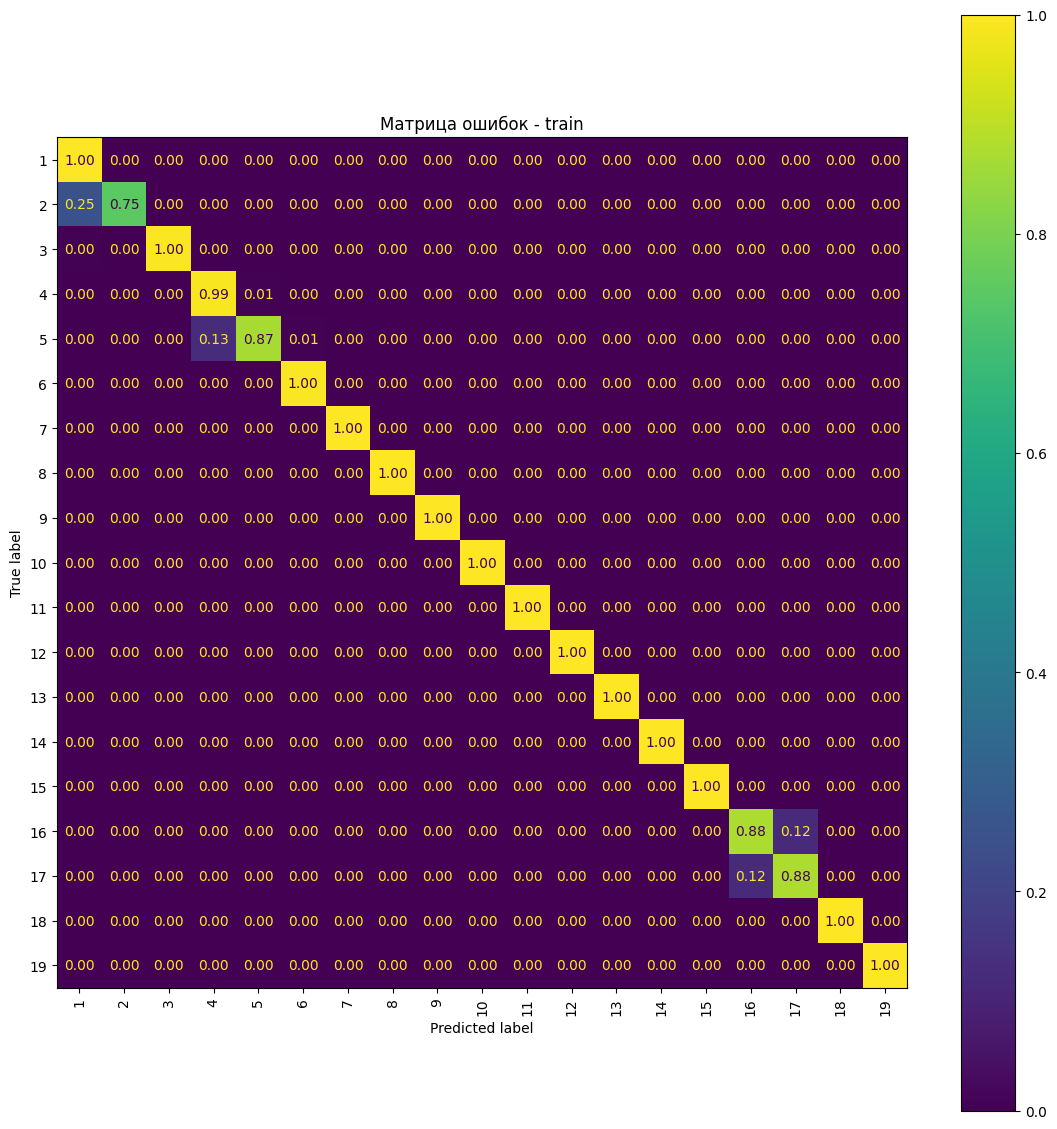

In [ ]:
plot_confusion(y_dev, y_dev_pred, title="Матрица ошибок - train")

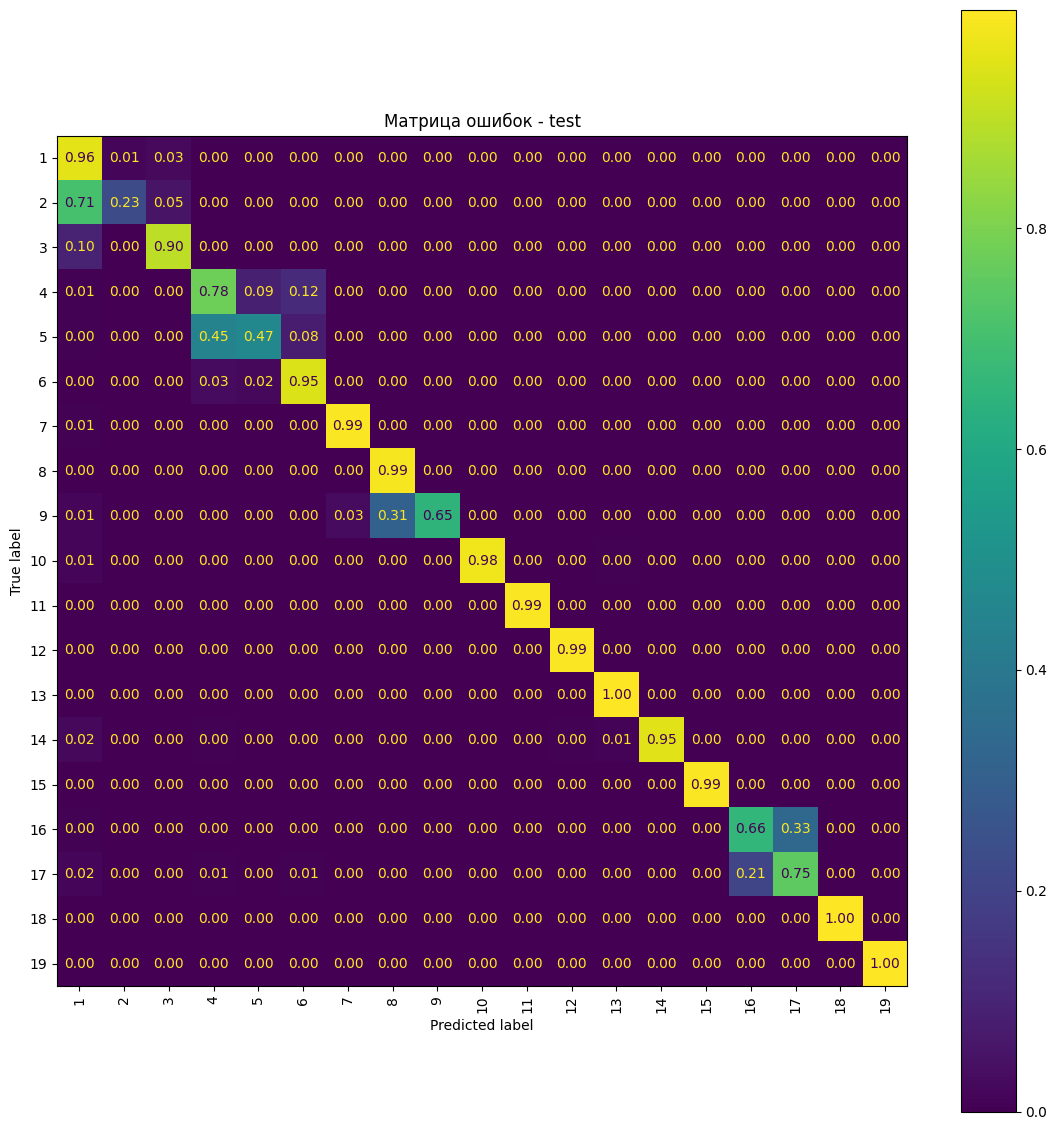

In [ ]:
plot_confusion(y_test, y_test_pred, title="Матрица ошибок - test")

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Literal
from sklearn.base import clone
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize


def _slice_X(X, idx):
    # X у вас pandas.DataFrame; но поддержим и numpy/sparse
    if hasattr(X, "iloc"):
        return X.iloc[idx]
    return X[idx]


def _get_final_estimator(est):
    # Pipeline -> последний clf, иначе сам est
    if hasattr(est, "named_steps") and "clf" in est.named_steps:
        return est.named_steps["clf"]
    return est


def _get_scores(est, X):
    """
    Вернёт:
      - multiclass: shape (n_samples, n_classes)
    """

    if hasattr(est, "predict_proba"):
        proba = est.predict_proba(X)
        return proba
    if hasattr(est, "decision_function"):
        dec = est.decision_function(X)
        return dec
    raise TypeError(
        "Estimator doesn't support predict_proba or decision_function; "
        "ROC needs continuous scores."
    )


@dataclass
class FoldRoc:
    fold: int
    auc_value: float
    fpr: np.ndarray
    tpr: np.ndarray


def plot_roc_per_fold_and_test(
    best_estimator,
    X_dev, y_dev,
    X_test, y_test,
    cv,
    *,
    multi_class : Literal["ovr", "ovo"],
    average_auc : Literal["micro", "macro", "weighted"],
    plot_chance_line : bool = True,
    title : str | None = None,
):
    """
    Строит ROC-кривые:
      - по каждому fold на X_dev (валидационная часть)
      - одну кривую на X_test (после fit на всём X_dev)
    Возвращает (fig, ax, fold_rocs, test_auc).
    """

    y_dev = np.asarray(y_dev)
    y_test = np.asarray(y_test)

    classes_all = np.unique(y_dev)
    n_classes = len(classes_all)

    fig, ax = plt.subplots(figsize=(8, 6))

    fold_rocs: list[FoldRoc] = []

    # --- CV ROC (по каждому fold) ---
    for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(X_dev, y_dev), start=1):
        est = clone(best_estimator)
        X_tr = _slice_X(X_dev, tr_idx)
        y_tr = y_dev[tr_idx]
        X_va = _slice_X(X_dev, va_idx)
        y_va = y_dev[va_idx]

        est.fit(X_tr, y_tr)

        scores = _get_scores(est, X_va)

        # multiclass: micro-average ROC curve
        # Привязываем порядок классов к classes_ конкретно обученного clf
        clf = _get_final_estimator(est)
        classes_est = getattr(clf, "classes_", classes_all)

        # scores ожидаем (n, n_classes)
        if scores.ndim != 2 or scores.shape[1] != len(classes_est):
            raise ValueError(
                f"Expected scores shape (n_samples, n_classes={len(classes_est)}), got {scores.shape}"
            )

        y_va_bin = label_binarize(y_va, classes=classes_est)
        # micro-average ROC: считаем ROC по всем классам сразу (flatten)
        fpr, tpr, _ = roc_curve(y_va_bin.ravel(), scores.ravel())

        # AUC как метрика: через roc_auc_score с multi_class. :contentReference[oaicite:5]{index=5}
        auc_val = roc_auc_score(
            y_va,
            scores,
            multi_class=multi_class,
            average=average_auc
        )

        fold_rocs.append(FoldRoc(fold=fold_idx, auc_value=float(auc_val), fpr=fpr, tpr=tpr))
        ax.plot(fpr, tpr, alpha=0.35, label=f"Fold {fold_idx}: AUC={auc_val:.3f}")

    # --- TEST ROC (fit на всём X_dev -> eval на X_test) ---
    est_final = clone(best_estimator).fit(X_dev, y_dev)
    scores_test = _get_scores(est_final, X_test)

    clf_final = _get_final_estimator(est_final)
    classes_est = getattr(clf_final, "classes_", classes_all)

    if scores_test.ndim != 2 or scores_test.shape[1] != len(classes_est):
        raise ValueError(
            f"Expected test scores shape (n_samples, n_classes={len(classes_est)}), got {scores_test.shape}"
        )

    y_test_bin = label_binarize(y_test, classes=classes_est)
    fpr_t, tpr_t, _ = roc_curve(y_test_bin.ravel(), scores_test.ravel())
    auc_test = roc_auc_score(
        y_test,
        scores_test,
        multi_class=multi_class,
        average=average_auc
    )

    ax.plot(fpr_t, tpr_t, linewidth=2.5, label=f"TEST: AUC={auc_test:.3f}")

    if plot_chance_line:
        ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title or "ROC curves per fold (dev) + test")
    ax.legend(loc="lower right")
    ax.grid(True)

    return fig, ax, fold_rocs, float(auc_test)

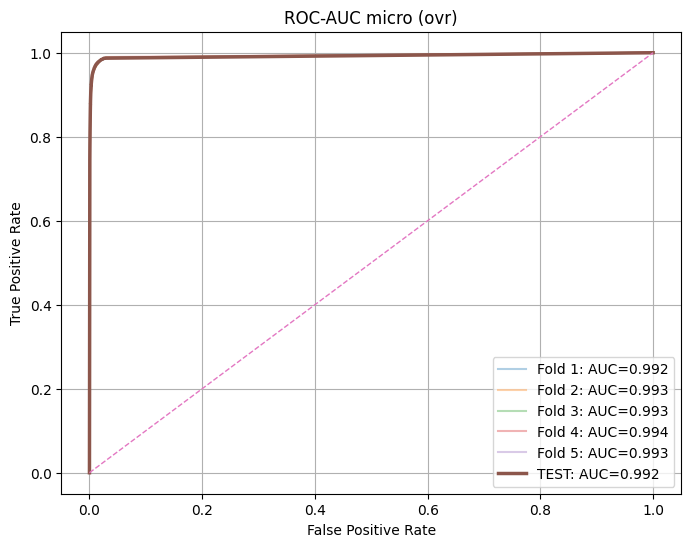

In [15]:
fig, ax, fold_rocs, test_auc = plot_roc_per_fold_and_test(
    best_estimator,
    X_dev, y_dev,
    X_test, y_test,
    cv=cv,
    multi_class="ovr",
    average_auc="micro",
    title="ROC-AUC micro (ovr)"
)
plt.show()

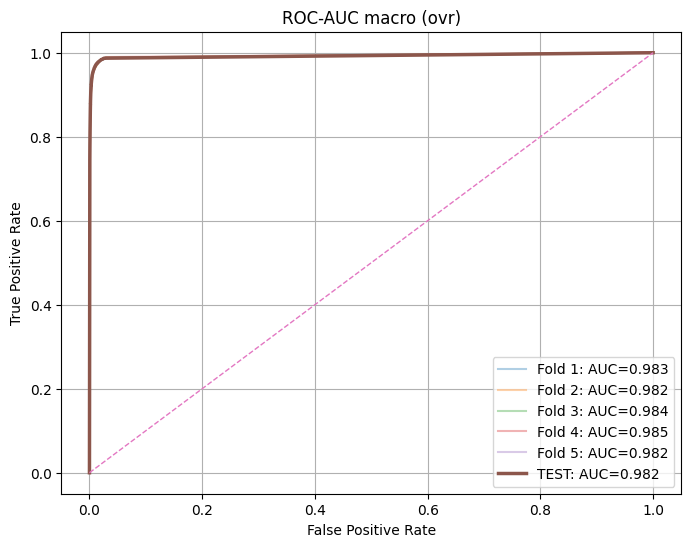

In [16]:
fig, ax, fold_rocs, test_auc = plot_roc_per_fold_and_test(
    best_estimator,
    X_dev, y_dev,
    X_test, y_test,
    cv=cv,
    multi_class="ovr",
    average_auc="macro",
    title="ROC-AUC macro (ovr)"
)
plt.show()

In [17]:
import sys, json, platform, sklearn, scipy, joblib, numpy as np
from sklearn.metrics import classification_report


out_dir = Path("models/2026-01-28_knn_cosine_v1")
out_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(best_estimator, out_dir / "model.joblib", compress=3)

(out_dir / "report_test.txt").write_text(
    classification_report(y_test, y_test_pred),
    encoding="utf-8"
)

clf = best_estimator["clf"]

meta = {
    "created_at": "2026-01-28T21:25:00Z",
    "python": sys.version,
    "platform": platform.platform(),
    "versions": {
        "sklearn": sklearn.__version__,
        "numpy": np.__version__,
        "scipy": scipy.__version__,
        "pandas": pd.__version__,
        "joblib": joblib.__version__,
    },
    "training": {
        "active_model": cfg["active_model"],
        "best_params": best_params or {},
        "clf_params": clf.get_params(),
        "best_score_val": float(best_score) if "best_score" in locals() else None,
        "scoring": "f1_weighted",
        "random_state_split": 42,
        "test_size": 0.15,
    },
    "model": {
        "type": type(clf).__qualname__,
        "classes": clf.classes_.tolist(),
    },
}
(out_dir / "meta.json").write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")

1039